# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [3]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [4]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

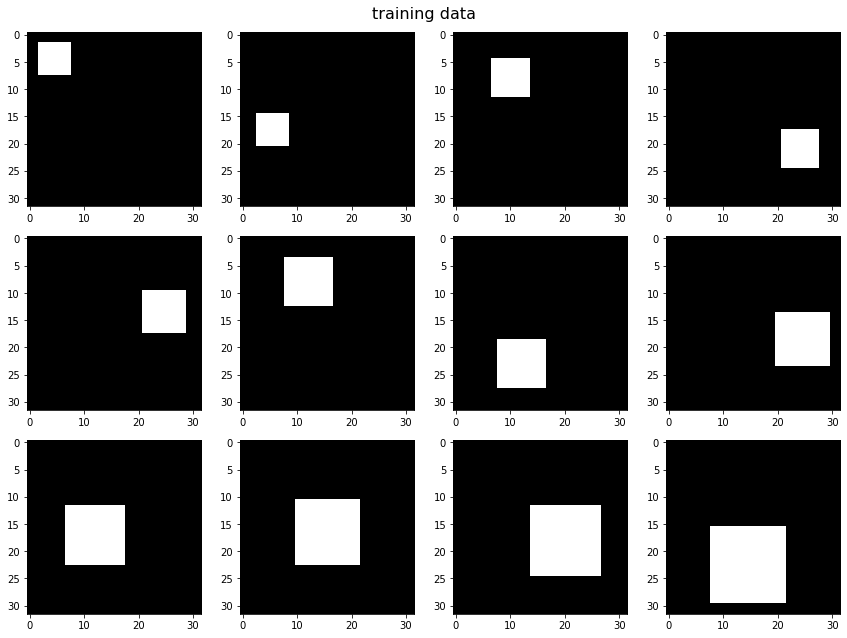

In [5]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [8]:
print(device)

cuda


In [9]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders 

In [10]:
size_minibatch  = 32
dim_latent      = 64 # input latent vector fixed dimension 

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [11]:
class Discriminator(nn.Module): 
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(1024),
#             nn.LeakyReLU(0.2),
        )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=1024, out_features=256, bias=True),
#             nn.LeakyReLU(0.2),
            
# #             nn.Linear(in_features=128, out_features=64, bias=True),
# #             nn.LeakyReLU(0.2),
            
# #             nn.Linear(in_features=64, out_features=32, bias=True),
# #             nn.LeakyReLU(0.2),
            
# #             nn.Linear(in_features=32, out_features=16, bias=True),
# #             nn.LeakyReLU(0.2),
            
#             nn.Linear(in_features=256, out_features=1, bias=True),
#         )
        
#         self.network = nn.Sequential(
#             self.conv,
#             nn.Flatten(),
            
#             self.classifier,
#         )
        
    def forward(self, x):
        out = self.conv(x)
        out = torch.flatten(out)
        
        return out


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.conv = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=dim_latent, out_channels=512, kernel_size=4, stride=1, padding=0, bias=True),
#             nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2),
            
#             nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(16),
#             nn.LeakyReLU(0.2),
            
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=2, stride=2, padding=0, bias=True),
#             nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            
            nn.Sigmoid()
        )
    
    def forward(self, x):
        
#         self.batch_size = x.size(0)

#         x = self.fc(x),
# #         print(x, len(x))
#         x = torch.reshape(x[0], [self.batch_size, 1, 32, 32])
        out = self.conv(x)
        
#         out = self.network(x)
        return out

## build network

In [13]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

optimizer_generator = torch.optim.AdamW(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

## compute the prediction

In [14]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [15]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [16]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [17]:
def train(generator, discriminator, dataloader):
    
    loss_generator_epoch = []
    loss_discriminator_epoch = []
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        
        optimizer_generator.zero_grad()
        fake = compute_prediction(generator, latent)
#         loss_image = nn.BCELoss()(fake, real)
        prediction_fake = compute_prediction(discriminator, fake)
        label_fake = torch.ones_like(prediction_fake)
        loss_label = nn.BCEWithLogitsLoss()(prediction_fake, label_fake)
#         loss_generator = 0.1 * loss_image + loss_label
        loss_generator = loss_label
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()
        
        optimizer_discriminator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_real = compute_prediction(discriminator, real)
        prediction_fake = compute_prediction(discriminator, fake)
        loss_real = nn.BCEWithLogitsLoss()(prediction_real, torch.ones_like(prediction_real, device=device))
        loss_fake = nn.BCEWithLogitsLoss()(prediction_fake, torch.zeros_like(prediction_fake, device=device))
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        loss_generator_epoch.append(loss_generator.item())
        loss_discriminator_epoch.append(loss_discriminator.item())
    
    return np.mean(loss_generator_epoch), np.mean(loss_discriminator_epoch)
        

## test

In [18]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [19]:
number_epoch    = 100
accuracy_epoch  = np.zeros(number_epoch)
loss_generator = np.zeros(number_epoch)
loss_discriminator = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in tqdm(range(number_epoch)):
    loss_generator_epoch, loss_discriminator_epoch = train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy
    
    loss_generator[i] = loss_generator_epoch
    loss_discriminator[i] = loss_discriminator_epoch
    tqdm.write(f'epoch {i}, loss_generator = {loss_generator_epoch}, loss_discriminator={loss_discriminator_epoch}, accuracy={accuracy}')

  1%|          | 1/100 [00:09<16:27,  9.97s/it]

epoch 0, loss_generator = 0.27908837854586266, loss_discriminator=0.05069771707855614, accuracy=38.28647994995117


  2%|▏         | 2/100 [00:17<13:39,  8.36s/it]

epoch 1, loss_generator = 0.0058854622645648546, loss_discriminator=0.00036986127276948, accuracy=41.763702392578125


  3%|▎         | 3/100 [00:24<12:30,  7.74s/it]

epoch 2, loss_generator = 0.007916470230729491, loss_discriminator=0.00020659465980888518, accuracy=44.936363220214844


  4%|▍         | 4/100 [00:30<11:14,  7.02s/it]

epoch 3, loss_generator = 0.0008480538747756293, loss_discriminator=6.495420594647941e-05, accuracy=45.282257080078125


  5%|▌         | 5/100 [00:35<10:27,  6.61s/it]

epoch 4, loss_generator = 0.0006145375569488991, loss_discriminator=4.8657934584534144e-05, accuracy=45.90927505493164


  6%|▌         | 6/100 [00:41<09:55,  6.34s/it]

epoch 5, loss_generator = 0.0004422952272256629, loss_discriminator=4.9844173082857636e-05, accuracy=45.569549560546875


  7%|▋         | 7/100 [00:47<09:33,  6.17s/it]

epoch 6, loss_generator = 0.0002326325468149864, loss_discriminator=2.796529874171096e-05, accuracy=48.23588562011719


  8%|▊         | 8/100 [00:53<09:18,  6.07s/it]

epoch 7, loss_generator = 0.00019069835177139827, loss_discriminator=2.0476873908558412e-05, accuracy=48.66431427001953


  9%|▉         | 9/100 [00:59<09:05,  6.00s/it]

epoch 8, loss_generator = 0.0001738041544471074, loss_discriminator=1.8040825468940764e-05, accuracy=46.92439270019531


 10%|█         | 10/100 [01:05<08:56,  5.96s/it]

epoch 9, loss_generator = 0.00015706141227080176, loss_discriminator=1.412254348704462e-05, accuracy=45.73443603515625


 11%|█         | 11/100 [01:11<08:48,  5.93s/it]

epoch 10, loss_generator = 0.0001640927050849078, loss_discriminator=1.331436456153083e-05, accuracy=44.7384033203125


 12%|█▏        | 12/100 [01:16<08:35,  5.86s/it]

epoch 11, loss_generator = 0.0002008186227478156, loss_discriminator=1.1524725010127036e-05, accuracy=43.773494720458984


 13%|█▎        | 13/100 [01:22<08:27,  5.83s/it]

epoch 12, loss_generator = 0.0002862241124535945, loss_discriminator=8.871568041757671e-06, accuracy=44.041015625


 14%|█▍        | 14/100 [01:28<08:21,  5.83s/it]

epoch 13, loss_generator = 0.00025562833406082874, loss_discriminator=7.750348433748715e-06, accuracy=43.359375


 15%|█▌        | 15/100 [01:34<08:15,  5.83s/it]

epoch 14, loss_generator = 0.00011348065063766963, loss_discriminator=6.96125281575843e-06, accuracy=44.4931640625


 16%|█▌        | 16/100 [01:40<08:09,  5.83s/it]

epoch 15, loss_generator = 3.510463732338933e-05, loss_discriminator=6.6692432213770826e-06, accuracy=45.2744140625


 17%|█▋        | 17/100 [01:45<08:03,  5.83s/it]

epoch 16, loss_generator = 2.212899102973838e-05, loss_discriminator=5.151432264096069e-06, accuracy=45.643836975097656


 18%|█▊        | 18/100 [01:51<07:57,  5.83s/it]

epoch 17, loss_generator = 2.248067817331671e-05, loss_discriminator=4.460959046439341e-06, accuracy=46.12592315673828


 19%|█▉        | 19/100 [01:57<07:51,  5.83s/it]

epoch 18, loss_generator = 1.6081610414807477e-05, loss_discriminator=3.9953820271842195e-06, accuracy=46.46600341796875


 20%|██        | 20/100 [02:03<07:47,  5.85s/it]

epoch 19, loss_generator = 1.2404032066923619e-05, loss_discriminator=3.5829799933843014e-06, accuracy=46.77989959716797


 21%|██        | 21/100 [02:09<07:42,  5.86s/it]

epoch 20, loss_generator = 1.1569385161338787e-05, loss_discriminator=3.2846538201906864e-06, accuracy=46.7526741027832


 22%|██▏       | 22/100 [02:15<07:36,  5.86s/it]

epoch 21, loss_generator = 1.1045450332016184e-05, loss_discriminator=2.969743339538885e-06, accuracy=46.367984771728516


 23%|██▎       | 23/100 [02:20<07:30,  5.86s/it]

epoch 22, loss_generator = 8.08671527044714e-06, loss_discriminator=2.775283605337285e-06, accuracy=45.83388137817383


 24%|██▍       | 24/100 [02:26<07:25,  5.86s/it]

epoch 23, loss_generator = 6.7186065684331375e-06, loss_discriminator=2.548455175336265e-06, accuracy=45.81318664550781


 25%|██▌       | 25/100 [02:32<07:19,  5.87s/it]

epoch 24, loss_generator = 6.911133793134165e-06, loss_discriminator=2.3589347687515396e-06, accuracy=45.939300537109375


 26%|██▌       | 26/100 [02:38<07:14,  5.87s/it]

epoch 25, loss_generator = 5.605468152646575e-06, loss_discriminator=2.284456645106224e-06, accuracy=45.22318649291992


 27%|██▋       | 27/100 [02:44<07:06,  5.85s/it]

epoch 26, loss_generator = 2.0656298475943106e-06, loss_discriminator=2.130754154239656e-06, accuracy=45.154449462890625


 28%|██▊       | 28/100 [02:50<07:00,  5.84s/it]

epoch 27, loss_generator = 2.613135851519204e-06, loss_discriminator=1.9000624762257858e-06, accuracy=45.13164520263672


 29%|██▉       | 29/100 [02:56<06:53,  5.82s/it]

epoch 28, loss_generator = 2.721638089429622e-06, loss_discriminator=1.7787285110494445e-06, accuracy=45.13555145263672


 30%|███       | 30/100 [03:01<06:47,  5.82s/it]

epoch 29, loss_generator = 1.9328441870432773e-06, loss_discriminator=1.6902598451485608e-06, accuracy=44.89081954956055


 31%|███       | 31/100 [03:07<06:40,  5.81s/it]

epoch 30, loss_generator = 1.5379641632130693e-06, loss_discriminator=1.6068962050094678e-06, accuracy=44.7032470703125


 32%|███▏      | 32/100 [03:13<06:35,  5.82s/it]

epoch 31, loss_generator = 1.9240967461613494e-06, loss_discriminator=1.4578571903324767e-06, accuracy=44.8547248840332


 33%|███▎      | 33/100 [03:19<06:31,  5.84s/it]

epoch 32, loss_generator = 2.0511978551372455e-06, loss_discriminator=1.3417938294811325e-06, accuracy=44.93077850341797


 34%|███▍      | 34/100 [03:25<06:23,  5.81s/it]

epoch 33, loss_generator = 1.7529544695409842e-06, loss_discriminator=1.2504276995699642e-06, accuracy=45.11378860473633


 35%|███▌      | 35/100 [03:30<06:19,  5.83s/it]

epoch 34, loss_generator = 1.6735645245986503e-06, loss_discriminator=1.1687197288497205e-06, accuracy=45.09895706176758


 36%|███▌      | 36/100 [03:36<06:12,  5.82s/it]

epoch 35, loss_generator = 1.7039738791195474e-06, loss_discriminator=1.0925583145156755e-06, accuracy=45.24375915527344


 37%|███▋      | 37/100 [03:42<06:05,  5.80s/it]

epoch 36, loss_generator = 1.6509920602335047e-06, loss_discriminator=1.0301114305851419e-06, accuracy=45.38917541503906


 38%|███▊      | 38/100 [03:48<05:58,  5.79s/it]

epoch 37, loss_generator = 1.4201348002879294e-06, loss_discriminator=9.671678446499788e-07, accuracy=45.45265197753906


 39%|███▉      | 39/100 [03:54<05:53,  5.79s/it]

epoch 38, loss_generator = 1.0903504108615313e-06, loss_discriminator=9.997295419621136e-07, accuracy=45.50127410888672


 40%|████      | 40/100 [03:59<05:48,  5.81s/it]

epoch 39, loss_generator = 2.986578422265935e-07, loss_discriminator=9.141031665859811e-07, accuracy=45.7194938659668


 41%|████      | 41/100 [04:05<05:43,  5.82s/it]

epoch 40, loss_generator = 2.1385922261069262e-07, loss_discriminator=8.10374629728122e-07, accuracy=45.88007354736328


 42%|████▏     | 42/100 [04:11<05:36,  5.80s/it]

epoch 41, loss_generator = 2.641092359462399e-07, loss_discriminator=7.493350738985571e-07, accuracy=46.12796401977539


 43%|████▎     | 43/100 [04:17<05:31,  5.82s/it]

epoch 42, loss_generator = 3.0845397839550935e-07, loss_discriminator=6.996645563756626e-07, accuracy=46.29951858520508


 44%|████▍     | 44/100 [04:23<05:24,  5.80s/it]

epoch 43, loss_generator = 3.307229353258326e-07, loss_discriminator=6.562028577011208e-07, accuracy=46.561466217041016


 45%|████▌     | 45/100 [04:28<05:19,  5.81s/it]

epoch 44, loss_generator = 3.8469823969670097e-07, loss_discriminator=6.110578712852859e-07, accuracy=46.72675323486328


 46%|████▌     | 46/100 [04:34<05:13,  5.81s/it]

epoch 45, loss_generator = 3.919004701334348e-07, loss_discriminator=5.694725970257692e-07, accuracy=46.924156188964844


 47%|████▋     | 47/100 [04:40<05:08,  5.81s/it]

epoch 46, loss_generator = 3.817456055693819e-07, loss_discriminator=5.372971301127379e-07, accuracy=47.05772399902344


 48%|████▊     | 48/100 [04:46<05:00,  5.79s/it]

epoch 47, loss_generator = 3.5666199033180926e-07, loss_discriminator=5.040178804291726e-07, accuracy=47.16351318359375


 49%|████▉     | 49/100 [04:52<04:54,  5.77s/it]

epoch 48, loss_generator = 3.423403202136628e-07, loss_discriminator=4.748226569130633e-07, accuracy=47.19019317626953


 50%|█████     | 50/100 [04:57<04:48,  5.78s/it]

epoch 49, loss_generator = 3.148559600234606e-07, loss_discriminator=4.3831482588319447e-07, accuracy=47.060020446777344


 51%|█████     | 51/100 [05:03<04:43,  5.78s/it]

epoch 50, loss_generator = 3.222513513450125e-07, loss_discriminator=4.111340093391778e-07, accuracy=47.020530700683594


 52%|█████▏    | 52/100 [05:09<04:36,  5.76s/it]

epoch 51, loss_generator = 3.2956395696399136e-07, loss_discriminator=3.848638178388447e-07, accuracy=46.993316650390625


 53%|█████▎    | 53/100 [05:15<04:31,  5.78s/it]

epoch 52, loss_generator = 3.132830592541588e-07, loss_discriminator=3.595318486515208e-07, accuracy=46.88557815551758


 54%|█████▍    | 54/100 [05:21<04:26,  5.80s/it]

epoch 53, loss_generator = 3.250660147050102e-07, loss_discriminator=3.3624188917942606e-07, accuracy=46.84761428833008


 55%|█████▌    | 55/100 [05:26<04:20,  5.78s/it]

epoch 54, loss_generator = 3.0517020545799085e-07, loss_discriminator=3.13448634448866e-07, accuracy=46.83259582519531


 56%|█████▌    | 56/100 [05:32<04:14,  5.78s/it]

epoch 55, loss_generator = 2.8196302663572066e-07, loss_discriminator=2.918971482038749e-07, accuracy=46.928462982177734


 57%|█████▋    | 57/100 [05:38<04:10,  5.82s/it]

epoch 56, loss_generator = 2.77658246945807e-07, loss_discriminator=2.755058742591414e-07, accuracy=47.09720993041992


 58%|█████▊    | 58/100 [05:44<04:04,  5.83s/it]

epoch 57, loss_generator = 2.757266160971186e-07, loss_discriminator=2.550029851936078e-07, accuracy=47.025238037109375


 59%|█████▉    | 59/100 [05:50<03:58,  5.83s/it]

epoch 58, loss_generator = 2.592801522454196e-07, loss_discriminator=2.3612818480429538e-07, accuracy=46.898826599121094


 60%|██████    | 60/100 [05:55<03:53,  5.83s/it]

epoch 59, loss_generator = 2.5287817219645215e-07, loss_discriminator=2.185227411170369e-07, accuracy=46.71949005126953


 61%|██████    | 61/100 [06:01<03:47,  5.84s/it]

epoch 60, loss_generator = 2.2597330918735545e-07, loss_discriminator=2.0646384118410626e-07, accuracy=46.430580139160156


 62%|██████▏   | 62/100 [06:07<03:41,  5.84s/it]

epoch 61, loss_generator = 1.7304660915400476e-07, loss_discriminator=1.9316317750255823e-07, accuracy=46.11088180541992


 63%|██████▎   | 63/100 [06:13<03:36,  5.85s/it]

epoch 62, loss_generator = 1.8463639898308664e-07, loss_discriminator=1.835326144230378e-07, accuracy=45.823089599609375


 64%|██████▍   | 64/100 [06:19<03:30,  5.86s/it]

epoch 63, loss_generator = 1.9407379833561815e-07, loss_discriminator=1.7304661483834665e-07, accuracy=45.55329513549805


 65%|██████▌   | 65/100 [06:25<03:25,  5.86s/it]

epoch 64, loss_generator = 1.6416110455523906e-07, loss_discriminator=1.656788199439958e-07, accuracy=45.398956298828125


 66%|██████▌   | 66/100 [06:31<03:19,  5.87s/it]

epoch 65, loss_generator = 1.7787568706521765e-07, loss_discriminator=1.557999035463177e-07, accuracy=45.238704681396484


 67%|██████▋   | 67/100 [06:37<03:13,  5.87s/it]

epoch 66, loss_generator = 1.757508928579699e-07, loss_discriminator=1.4967387140056114e-07, accuracy=45.147979736328125


 68%|██████▊   | 68/100 [06:42<03:07,  5.86s/it]

epoch 67, loss_generator = 1.6882461464033608e-07, loss_discriminator=1.4194734395308237e-07, accuracy=45.13182067871094


 69%|██████▉   | 69/100 [06:48<03:00,  5.84s/it]

epoch 68, loss_generator = 1.6242263617035254e-07, loss_discriminator=1.347451165690506e-07, accuracy=45.07661437988281


 70%|███████   | 70/100 [06:54<02:55,  5.86s/it]

epoch 69, loss_generator = 1.4768704701324437e-07, loss_discriminator=1.2787402741625758e-07, accuracy=45.075599670410156


 71%|███████   | 71/100 [07:00<02:49,  5.84s/it]

epoch 70, loss_generator = 1.3664915251688904e-07, loss_discriminator=1.1948522687480026e-07, accuracy=45.15523910522461


 72%|███████▏  | 72/100 [07:06<02:43,  5.85s/it]

epoch 71, loss_generator = 1.276532686305203e-07, loss_discriminator=1.0690202572050111e-07, accuracy=45.229835510253906


 73%|███████▎  | 73/100 [07:12<02:37,  5.83s/it]

epoch 72, loss_generator = 1.303023628485823e-07, loss_discriminator=9.793373441913933e-08, accuracy=45.23387145996094


 74%|███████▍  | 74/100 [07:17<02:31,  5.83s/it]

epoch 73, loss_generator = 1.2610796307786518e-07, loss_discriminator=8.47158528611342e-08, accuracy=45.157257080078125


 75%|███████▌  | 75/100 [07:23<02:25,  5.83s/it]

epoch 74, loss_generator = 1.357661208477044e-07, loss_discriminator=7.119442984120454e-08, accuracy=45.09273910522461


 76%|███████▌  | 76/100 [07:29<02:19,  5.82s/it]

epoch 75, loss_generator = 1.337793003025817e-07, loss_discriminator=5.927350249142667e-08, accuracy=44.933467864990234


 77%|███████▋  | 77/100 [07:35<02:13,  5.83s/it]

epoch 76, loss_generator = 1.3441397833781188e-07, loss_discriminator=4.961534331366019e-08, accuracy=44.79838562011719


 78%|███████▊  | 78/100 [07:41<02:08,  5.83s/it]

epoch 77, loss_generator = 1.3709066756198942e-07, loss_discriminator=3.711492599346979e-08, accuracy=44.776206970214844


 79%|███████▉  | 79/100 [07:46<02:02,  5.82s/it]

epoch 78, loss_generator = 1.5204701487324132e-07, loss_discriminator=2.8753719701531583e-08, accuracy=44.95161056518555


 80%|████████  | 80/100 [07:52<01:56,  5.82s/it]

epoch 79, loss_generator = 1.6520970441896914e-07, loss_discriminator=2.011656594553741e-08, accuracy=44.96471405029297


 81%|████████  | 81/100 [07:58<01:50,  5.84s/it]

epoch 80, loss_generator = 1.8046959358689156e-07, loss_discriminator=1.5177107437480687e-08, accuracy=45.0625


 82%|████████▏ | 82/100 [08:04<01:44,  5.80s/it]

epoch 81, loss_generator = 1.608221410791615e-07, loss_discriminator=1.208649651638525e-08, accuracy=45.212703704833984


 83%|████████▎ | 83/100 [08:10<01:38,  5.79s/it]

epoch 82, loss_generator = 1.6371958861538116e-07, loss_discriminator=9.768538312405474e-09, accuracy=45.36592483520508


 84%|████████▍ | 84/100 [08:15<01:32,  5.78s/it]

epoch 83, loss_generator = 1.7718582038620903e-07, loss_discriminator=5.988058786270072e-09, accuracy=45.51512145996094


 85%|████████▌ | 85/100 [08:21<01:26,  5.79s/it]

epoch 84, loss_generator = 1.4972905672847345e-07, loss_discriminator=5.850085089604746e-09, accuracy=45.61289978027344


 86%|████████▌ | 86/100 [08:27<01:20,  5.78s/it]

epoch 85, loss_generator = 1.3005401026728375e-07, loss_discriminator=5.98805874844025e-09, accuracy=45.58871078491211


 87%|████████▋ | 87/100 [08:33<01:15,  5.79s/it]

epoch 86, loss_generator = 1.2939173754173477e-07, loss_discriminator=3.6149110684259835e-09, accuracy=45.757057189941406


 88%|████████▊ | 88/100 [08:39<01:09,  5.81s/it]

epoch 87, loss_generator = 1.2108572259758484e-07, loss_discriminator=4.6359164671714464e-09, accuracy=45.688507080078125


 89%|████████▉ | 89/100 [08:44<01:03,  5.79s/it]

epoch 88, loss_generator = 1.2089255923902548e-07, loss_discriminator=3.863263727028939e-09, accuracy=45.74092483520508


 90%|█████████ | 90/100 [08:50<00:58,  5.81s/it]

epoch 89, loss_generator = 1.2006471837156386e-07, loss_discriminator=3.780479512977203e-09, accuracy=45.818546295166016


 91%|█████████ | 91/100 [08:56<00:52,  5.82s/it]

epoch 90, loss_generator = 1.2025788130906086e-07, loss_discriminator=2.53871619035648e-09, accuracy=45.7049560546875


 92%|█████████▏| 92/100 [09:02<00:46,  5.84s/it]

epoch 91, loss_generator = 1.2108572291338162e-07, loss_discriminator=3.311368923919889e-09, accuracy=45.06589889526367


 93%|█████████▎| 93/100 [09:08<00:40,  5.84s/it]

epoch 92, loss_generator = 1.222722959129088e-07, loss_discriminator=2.92504255220386e-09, accuracy=45.053897857666016


 94%|█████████▍| 94/100 [09:14<00:35,  5.86s/it]

epoch 93, loss_generator = 1.2508695806235226e-07, loss_discriminator=3.504532103198804e-09, accuracy=45.435543060302734


 95%|█████████▌| 95/100 [09:20<00:29,  5.84s/it]

epoch 94, loss_generator = 1.260251799016664e-07, loss_discriminator=2.207579278227193e-09, accuracy=45.79174041748047


 96%|█████████▌| 96/100 [09:25<00:23,  5.85s/it]

epoch 95, loss_generator = 1.2089255944955666e-07, loss_discriminator=2.0696055733379932e-09, accuracy=45.95976638793945


 97%|█████████▋| 97/100 [09:31<00:17,  5.84s/it]

epoch 96, loss_generator = 1.2307254319534035e-07, loss_discriminator=1.7660634288318987e-09, accuracy=46.06334686279297


 98%|█████████▊| 98/100 [09:37<00:11,  5.81s/it]

epoch 97, loss_generator = 1.2329330055999216e-07, loss_discriminator=2.152389808771802e-09, accuracy=46.1318359375


 99%|█████████▉| 99/100 [09:43<00:05,  5.80s/it]

epoch 98, loss_generator = 1.2558366290915256e-07, loss_discriminator=1.6004949694777055e-09, accuracy=45.9365234375


100%|██████████| 100/100 [09:49<00:00,  5.89s/it]

epoch 99, loss_generator = 1.3157172070855772e-07, loss_discriminator=1.9316318635144695e-09, accuracy=46.06640625


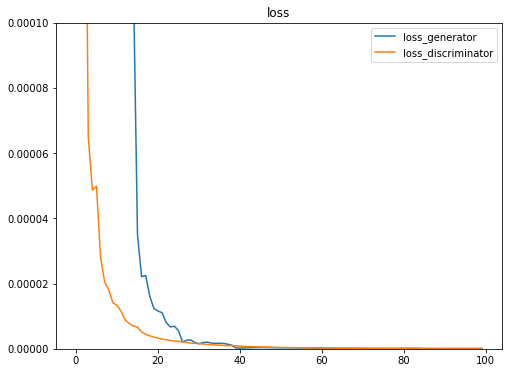

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(loss_generator, label='loss_generator')
plt.plot(loss_discriminator, label='loss_discriminator')
plt.ylim(0,0.0001)
plt.legend()
plt.title('loss')
plt.show()

---

# functions for presenting the results

---

In [25]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [26]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [27]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



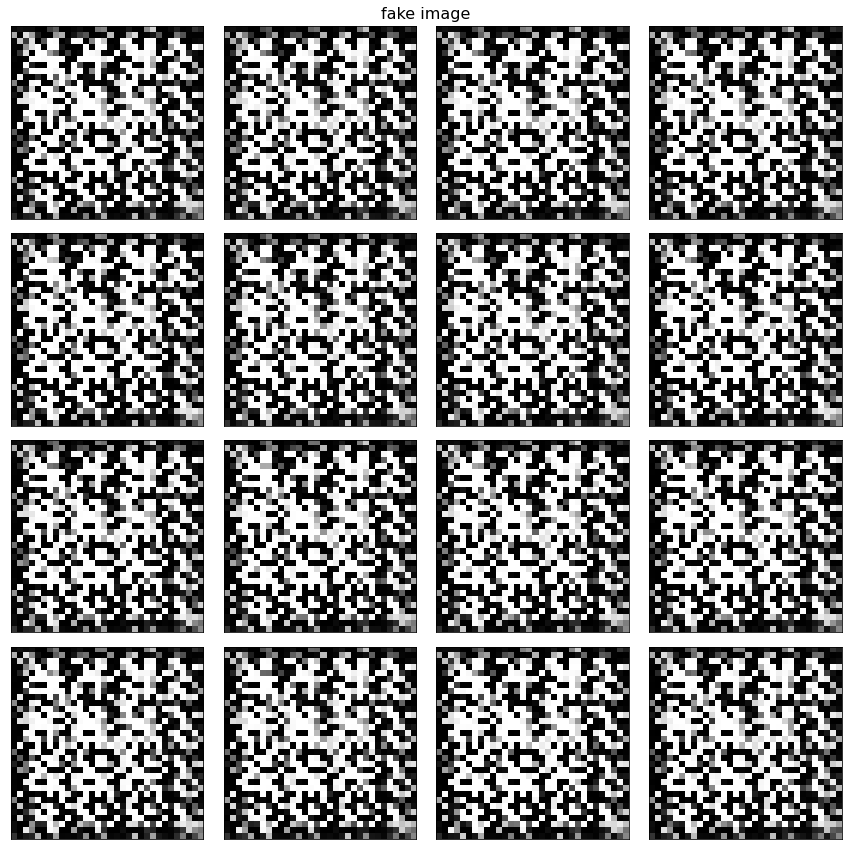

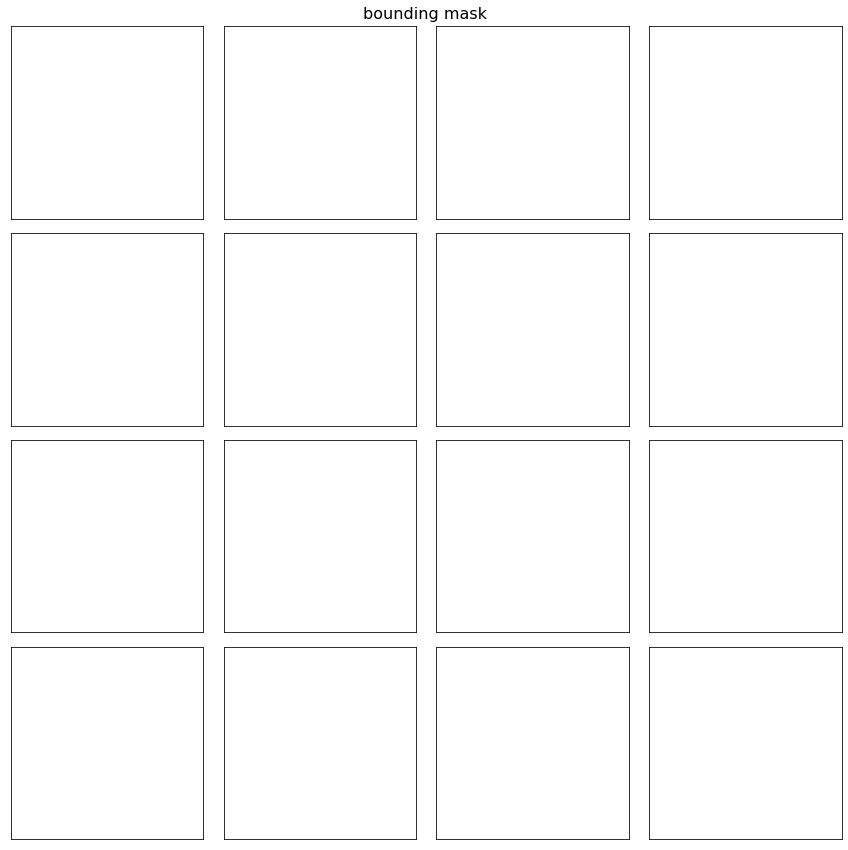


################################################################################
#
# RESULT # 02
#
################################################################################



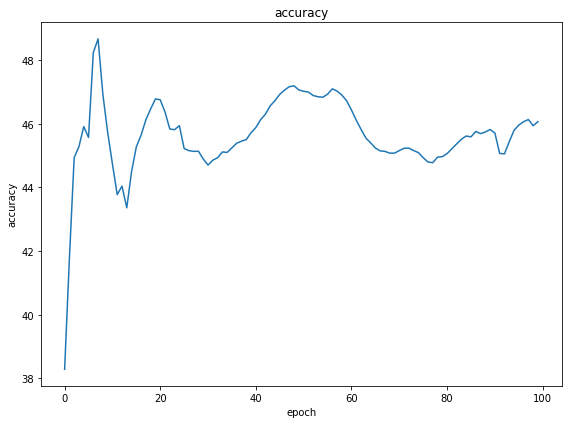


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 46.06640625


In [28]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)